In [1]:
import pyarrow.parquet as pq
import pandas as pd

metadata_path = r"C:\Users\mayer\Работен плот\final forest detector\metadata.parquet"

# # table = pq.read_table(metadata_path)
# # df = table.to_pandas()
# print("Available columns in metadata:", df.columns.tolist())

#print(df.head())
#print(df.columns)

In [90]:
# INSTALL DEPENDENCIES (Colab only)
!pip install torch torchvision

# IMPORTS
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import rasterio 
# CUSTOM DATASET
import rasterio
import json

%pip install tqdm
from tqdm import tqdm
#loads the data from the BigEarthNet dataset, which is the strangly configurated one 
%pip install pandas 
import pandas as pd

%pip install pyarrow
import pyarrow

%pip install fastparquet
import fastparquet
metadata_path = r"C:\Users\mayer\Работен плот\final forest detector\metadata.parquet"

import pyarrow as pa
import pyarrow.parquet as pq

table = pq.read_table(metadata_path)
df = table.to_pandas()

class BigEarthNetVegetationDataset(Dataset):
    def __init__(self, root_dir, transform=None, metadata_file="metadata.parquet", filter_cloud=True):
        self.root_dir = root_dir
        self.samples = []
        self.transform = transform

        # Load metadata
        #metadata_path = os.path.join(root_dir, metadata_file)
        metadata_path = r"C:\Users\mayer\Работен плот\final forest detector\metadata.parquet"
        import pyarrow.parquet as pq
        table = pq.read_table(metadata_path)
        df = table.to_pandas()

        # Optional: remove patches with clouds/snow
        if filter_cloud:
            if "contains_cloud_or_shadow" in df.columns:
                df = df[df["contains_cloud_or_shadow"] == False]
            if "contains_seasonal_snow" in df.columns:
                df = df[df["contains_seasonal_snow"] == False]

        # Forest label set
        self.forest_labels = set([
            "Forest", "Broad-leaved forest", "Coniferous forest",
            "Mixed forest", "Transitional woodland, shrub"
        ])
        # Add binary label column
        df["binary_label"] = df["labels"].apply(lambda labels: 1.0 if set(labels) & self.forest_labels else 0.0)

        # Select 10 samples with forest and 10 without
        forest_df = df[df["binary_label"] == 1.0].sample(n=15000, random_state=42)
        non_forest_df = df[df["binary_label"] == 0.0].sample(n=15000, random_state=42)
        df = pd.concat([forest_df, non_forest_df]).reset_index(drop=True)


        for _, row in df.iterrows():
            patch_id = row["patch_id"]
            labels = set(row["labels"])

            # Map to binary: forest vs. no forest
            binary_label = 1.0 if labels & self.forest_labels else 0.0

            # Locate patch folder inside the root folder
            found = False
            for tile_folder in os.listdir(root_dir):
                tile_path = os.path.join(root_dir, tile_folder)
                patch_path = os.path.join(tile_path, patch_id)
                if os.path.isdir(patch_path):
                    found = True
                    break

            if not found:
                continue  # Skip if folder not found

            try:
                # Load Sentinel-2 bands
                blue = rasterio.open(os.path.join(patch_path, patch_id + "_B02.tif")).read(1).astype(np.float32) / 10000.0
                green = rasterio.open(os.path.join(patch_path, patch_id + "_B03.tif")).read(1).astype(np.float32) / 10000.0
                red = rasterio.open(os.path.join(patch_path, patch_id + "_B04.tif")).read(1).astype(np.float32) / 10000.0
                nir = rasterio.open(os.path.join(patch_path, patch_id + "_B08.tif")).read(1).astype(np.float32) / 10000.0

                # Compute NDVI
                ndvi = (nir - red) / (nir + red + 1e-5)

                # Stack channels: [4, H, W]
                stacked = np.stack([red, green, blue, ndvi], axis=0)

                self.samples.append((stacked, binary_label))

            except Exception as e:
                print(f"Skipping {patch_id} due to error: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, label = self.samples[idx]
        tensor = torch.tensor(image, dtype=torch.float32)
        tensor = F.interpolate(tensor.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
        return tensor, torch.tensor(label, dtype=torch.float32)



class VegetationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []

        for label, subfolder in enumerate(['NO_VEGETATION', 'VEGETATION']):
            folder = os.path.join(root_dir, subfolder)
            for file in os.listdir(folder):
                if file.endswith(('.npy', '.tif', '.tiff')):
                    self.samples.append((os.path.join(folder, file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        if path.endswith('.npy'):
            array = np.load(path)  # shape: [H, W, 15]
            red = array[:, :, 3] / 10000.0
            green = array[:, :, 2] / 10000.0
            blue = array[:, :, 1] / 10000.0
            ndvi = array[:, :, 13]
        elif path.endswith(('.tif', '.tiff')):
            with rasterio.open(path) as src:
                try:
                    red = src.read(4).astype(np.float32) / 10000.0
                    green = src.read(3).astype(np.float32) / 10000.0
                    blue = src.read(2).astype(np.float32) / 10000.0
                    nir = src.read(8).astype(np.float32) / 10000.0
                except IndexError:
                    raise ValueError(f"{os.path.basename(path)} doesn't contain required bands 2, 3, 4, and 8")
                ndvi = (nir - red) / (nir + red + 1e-5)
        else:
            raise ValueError(f"Unsupported file format: {path}")

        # Stack and resize
        stacked = np.stack([red, green, blue, ndvi], axis=0)  # [4, H, W]
        tensor = torch.tensor(stacked, dtype=torch.float32)
        tensor = F.interpolate(tensor.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)

        return tensor, torch.tensor(label, dtype=torch.float32)

#  MODEL
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # assuming 64x64 patches
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 16, 16]
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

#  TRAINING SETUP
def train_model(dataset_path, num_epochs=10, batch_size=32):
    dataset = BigEarthNetVegetationDataset(dataset_path)
   # dataset = VegetationDataset(dataset_path)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = SimpleCNN(in_channels=4)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for images, labels in progress:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress.set_postfix(loss=loss.item())
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {total_loss/len(train_loader):.4f}")
        loss_history.append(avg_loss)

    return model, loss_history



#  EVALUATION FUNCTION
def evaluate_model(model, val_loader):
    model.eval()
    device = next(model.parameters()).device
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).squeeze() > 0.5
            correct += (outputs == labels).sum().item()
            total += labels.size(0)
    print(f"Validation Accuracy: {correct / total:.2%}")

from PIL import Image

def predict(model, image_path):
    # Detect file type
    if image_path.endswith('.npy'):
        array = np.load(image_path)  # shape: [H, W, 15]
        red = array[:, :, 3] / 10000.0
        green = array[:, :, 2] / 10000.0
        blue = array[:, :, 1] / 10000.0
        ndvi = array[:, :, 13]

        # Stack to [4, H, W]
        stacked = np.stack([red, green, blue, ndvi], axis=0)
    elif image_path.endswith('.png') or image_path.endswith('.jpg'):
        img = Image.open(image_path).convert('RGB')
        img = img.resize((64, 64))  # Resize for consistency
        img = np.array(img).astype(np.float32) / 255.0

        red = img[:, :, 0]
        green = img[:, :, 1]
        blue = img[:, :, 2]
        ndvi = np.zeros_like(red)

        # Stack to [4, 64, 64]
        stacked = np.stack([red, green, blue, ndvi], axis=0)

    elif image_path.endswith('.tif') or image_path.endswith('.tiff'):
        import rasterio
        with rasterio.open(image_path) as src:
        # Read bands using Sentinel-2 standard band numbers:
        # Band 4 = red (index 4)
        # Band 3 = green (index 3)
        # Band 2 = blue (index 2)
        # Band 8 = NIR (index 8)
         red = src.read(4).astype(np.float32) / 10000.0
         green = src.read(3).astype(np.float32) / 10000.0
         blue = src.read(2).astype(np.float32) / 10000.0
         nir = src.read(8).astype(np.float32) / 10000.0

        # Compute NDVI
         ndvi = (nir - red) / (nir + red + 1e-5)

        # Stack to [4, H, W]
         stacked = np.stack([red, green, blue, ndvi], axis=0)
    else:
        raise ValueError("Unsupported file format. Use .npy or .png/.jpg")

    # Resize if needed (for .npy)
    if stacked.shape[1:] != (64, 64):
        tensor = torch.tensor(stacked, dtype=torch.float32).unsqueeze(0)  # [1, 4, H, W]
        tensor = F.interpolate(tensor, size=(64, 64), mode='bilinear', align_corners=False)
    else:
        tensor = torch.tensor(stacked, dtype=torch.float32).unsqueeze(0)

    # Predict
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        prob = model(tensor.to(device)).item()
        label = "VEGETATION" if prob > 0.5 else "NO_VEGETATION"
   
   # visualize = true 
    import matplotlib.pyplot as plt

    rgb_vis = np.stack([red, green, blue], axis=-1)
    rgb_vis = np.clip(rgb_vis, 0, 1)
    plt.figure(figsize=(4, 4))
    plt.imshow(rgb_vis)
    plt.title(f"Prediction: {label}", fontsize=14, color='green' if label == "VEGETATION" else 'red')
    plt.axis('off')
    plt.show()
  

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [50]:
dataset_path = r'C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2'
dataset = BigEarthNetVegetationDataset(dataset_path)
print(f"Loaded {len(dataset)} samples")



'''
print("Example labels:")
for i in range(min(110, len(dataset.samples))):
    print(dataset.samples[i][1])
'''


Loaded 2000 samples


'\nprint("Example labels:")\nfor i in range(min(110, len(dataset.samples))):\n    print(dataset.samples[i][1])\n'

In [57]:
import rasterio
import numpy as np
import os

patch_path = r"C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57"

bands = ['B04', 'B03', 'B02', 'B08']  # Red, Green, Blue, NIR
images = []

for band in bands:
    file_path = os.path.join(patch_path, os.path.basename(patch_path) + f'_{band}.tif')
    with rasterio.open(file_path) as src:
        img = src.read(1).astype(np.float32) / 10000.0
        images.append(img)

red, green, blue, nir = images
ndvi = (nir - red) / (nir + red + 1e-6)

stacked = np.stack([red, green, blue, ndvi])
print(f"Image shape: {stacked.shape}")

Image shape: (4, 120, 120)


Example labels:


NameError: name 'self' is not defined

Epoch 1/15: 100%|██████████| 750/750 [02:39<00:00,  4.71batch/s, loss=0.319]


Epoch 1/15, Avg Loss: 0.4225


Epoch 2/15: 100%|██████████| 750/750 [01:17<00:00,  9.67batch/s, loss=0.225]


Epoch 2/15, Avg Loss: 0.3564


Epoch 3/15: 100%|██████████| 750/750 [01:13<00:00, 10.19batch/s, loss=0.275] 


Epoch 3/15, Avg Loss: 0.3309


Epoch 4/15: 100%|██████████| 750/750 [01:20<00:00,  9.27batch/s, loss=0.322] 


Epoch 4/15, Avg Loss: 0.3118


Epoch 5/15: 100%|██████████| 750/750 [03:53<00:00,  3.21batch/s, loss=0.147]  


Epoch 5/15, Avg Loss: 0.2939


Epoch 6/15: 100%|██████████| 750/750 [01:14<00:00, 10.09batch/s, loss=0.484]


Epoch 6/15, Avg Loss: 0.2820


Epoch 7/15: 100%|██████████| 750/750 [01:16<00:00,  9.78batch/s, loss=0.243] 


Epoch 7/15, Avg Loss: 0.2568


Epoch 8/15: 100%|██████████| 750/750 [01:20<00:00,  9.34batch/s, loss=0.495] 


Epoch 8/15, Avg Loss: 0.2369


Epoch 9/15: 100%|██████████| 750/750 [01:25<00:00,  8.75batch/s, loss=0.0762]


Epoch 9/15, Avg Loss: 0.2095


Epoch 10/15: 100%|██████████| 750/750 [01:19<00:00,  9.48batch/s, loss=0.251] 


Epoch 10/15, Avg Loss: 0.1835


Epoch 11/15: 100%|██████████| 750/750 [01:15<00:00,  9.90batch/s, loss=0.0484]


Epoch 11/15, Avg Loss: 0.1503


Epoch 12/15: 100%|██████████| 750/750 [01:19<00:00,  9.43batch/s, loss=0.0802]


Epoch 12/15, Avg Loss: 0.1295


Epoch 13/15: 100%|██████████| 750/750 [04:13<00:00,  2.96batch/s, loss=0.13]    


Epoch 13/15, Avg Loss: 0.1119


Epoch 14/15: 100%|██████████| 750/750 [01:13<00:00, 10.21batch/s, loss=0.0761] 


Epoch 14/15, Avg Loss: 0.0914


Epoch 15/15: 100%|██████████| 750/750 [01:17<00:00,  9.69batch/s, loss=0.0937] 


Epoch 15/15, Avg Loss: 0.0683


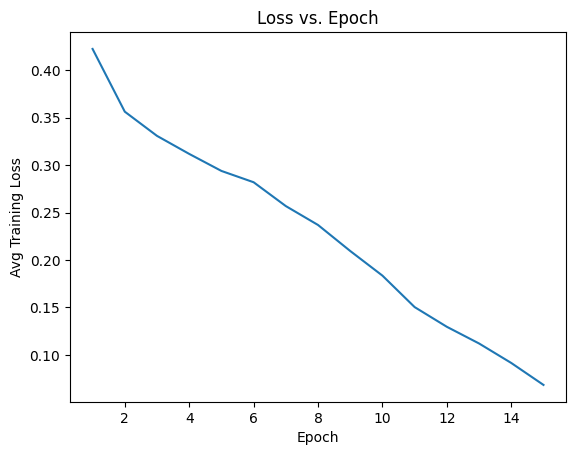

Total dataset size: 30000
Validation set size: 6000
Accuracy: 51.57%


0.5156666666666667

In [92]:
import zipfile
import os
import matplotlib.pyplot as plt

# Local path to the ZIP file
#zip_path = r"C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP"

# Folder where the data will be extracted
#extracted_path = r"C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP"

# Only extract if not already extracted
'''
if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

'''
from torch.utils.data import random_split
dataset_path=r"C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2"
dataset = BigEarthNetVegetationDataset(dataset_path)
#dataset = VegetationDataset(dataset_path)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            preds = torch.round(torch.sigmoid(outputs)).squeeze()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")  # Shows 0-100%
    return accuracy
# Train the model using the extracted folder
model, loss_history = train_model(dataset_path=r"C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2", num_epochs=15, batch_size=32)

plt.plot(range(1, len(loss_history)+1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Avg Training Loss")
plt.title("Loss vs. Epoch")
plt.show()


from torch.utils.data import DataLoader

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(f"Total dataset size: {len(dataset)}")
print(f"Validation set size: {len(val_dataset)}")
# After model has finished training
evaluate_model(model, val_loader)

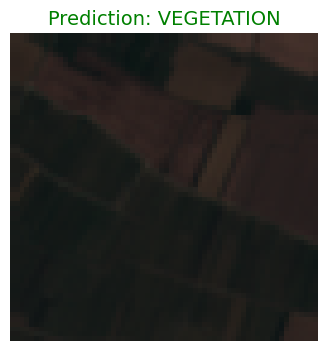

None


In [80]:

import zipfile
import os


testFile_path = r"C:\Users\mayer\Работен плот\final forest detector\photos from DIego previous project\PermanentCrop_1.tif" # Get the uploaded filename
result = predict(model, testFile_path)
print(result)